# Hierarchical Clustering by Decade
@author: Thomas Lu, UC Berkeley; Nancy Xu, UC Berkeley<br>
@coauthors: Jaren Haber, PhD, Dartmouth College<br>
@contact: jhaber@berkeley.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@date_created: March 27, 2022
@date_modified: May 17, 2022

@description: '''Conducts hierarchical clustering (agglomerative) on the word vectors from pretrained word2vec models. Includes clusters seeded on expert-coded lexicons and clustering on only those seed terms. Visualize TSNE plots and dendrograms of the clusters.

@inputs: decade-specific word embedding models, core dictionaries <br>
@outputs: dendrograms/cluster visualizations
'''

## Initialize

In [39]:
# Import packages: general
import re # For filtering most_similar() output--remove surnames
import csv # For saving csv files
import pandas as pd
import numpy as np
from os.path import join, isfile, isdir
from os import getcwd
import _pickle as cPickle # Optimized version of pickle
from collections import Counter # For counting terms across the corpus
from itertools import combinations
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date
import warnings
warnings.filterwarnings('ignore')

# Import packages: word vectors and clustering
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE # For visualizing word embeddings
from scipy.spatial import distance # To use cosine distances for tSNE metric
import scipy.cluster.hierarchy as shc
from scipy.cluster import hierarchy

# Define filepaths
cwd = getcwd()
root = str.replace(cwd, 'embeddings/clustering', '')
FIGURES_HOME = join(root, 'embeddings/figures/dendrograms')
DICTS_HOME = join(root, 'dictionary_methods/dictionaries/expanded_decades')
MODELS_HOME = join(root, 'models_storage/w2v_models')

## Load models

In [113]:
wem_path_1970s = join(MODELS_HOME, 'word2vec_1971-1981_phrased_filtered_enchant_orgdict_300d_10w_020423.bin')
wem_path_1980s = join(MODELS_HOME, 'word2vec_1982-1992_phrased_filtered_enchant_orgdict_300d_10w_020423.bin')
wem_path_1990s = join(MODELS_HOME, 'word2vec_1993-2003_phrased_filtered_enchant_orgdict_300d_10w_020423.bin')
wem_path_2000s = join(MODELS_HOME, 'word2vec_2004-2014_phrased_filtered_enchant_orgdict_300d_10w_020423.bin')

w2v_1970s = KeyedVectors.load(wem_path_1970s)
w2v_1980s = KeyedVectors.load(wem_path_1980s)
w2v_1990s = KeyedVectors.load(wem_path_1990s)
w2v_2000s = KeyedVectors.load(wem_path_2000s)

models = [w2v_1970s, w2v_1980s, w2v_1990s, w2v_2000s]

decades = [
    '1971-1981',
    '1982-1992',
    '1993-2003',
    '2004-2014',
]

## Agglomerative Clustering 

### Define dendrogram functions

In [117]:
def plot_dendrogram(model, 
                    linkage='average',
                    figsize=(20,10), 
                    color_labels=None, 
                    yrange=None, 
                    xrange=None,
                    title="Dendrogram", 
                    save_plot=None, 
                    **kwargs):
    '''Create linkage matrix and then plot the dendrogram'''
    
    global FIGURES_HOME

    # create the counts of samples under each node
    fig = plt.figure(figsize=figsize)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    children, distances, counts = model.children_, model.distances_, np.array(counts)

    linkage_matrix = np.column_stack(
        [children, distances, counts]
    ).astype(float)
    
    cluster_threshold = 0.7*max(linkage_matrix[:,2])
    print(f'cluster threshold: {cluster_threshold}')

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    ax = plt.gca()
    
    # Customize plot layout by dendrogram orientation
    if orientation == 'top': # 'top' orientation
        ax.set_ylim(yrange)
        plt.axhline(y=cluster_threshold, c='k', linestyle='dashed')
        ax.set_ylabel(f'{linkage.title()} linkage distance', fontsize = 24)
        if color_labels:
            xlbls = ax.get_xmajorticklabels()
            for lbl in xlbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
                      
    elif orientation == 'right': # 'right' orientation
        ax.set_xlim(xrange)
        plt.axvline(x=cluster_threshold, c='k', linestyle='dashed')
        ax.set_xlabel(f'{linkage.title()} linkage distance', fontsize = 12)
        if color_labels:
            ylbls = ax.get_ymajorticklabels()
            for lbl in ylbls:
                lbl.set_color(color_labels.get(lbl.get_text(), 'black'))
    
    plt.title(title)
    if save_plot:
        assert isdir(FIGURES_HOME), f"ERROR: {FIGURES_HOME} not a valid target location for saving dendrogram"
        filepath = join(FIGURES_HOME, str(save_plot) + ".png")
        plt.savefig(filepath, bbox_inches='tight', dpi = 600)
    plt.show()

def get_cluster_words(model, label, labels):
    words = []
    for i, word in enumerate(labels):
        if labels[i] == label:
            words.append(word)
    return words

In [150]:
def cluster_and_visualize(model, 
                          linkage='average', 
                          affinity='precomputed',
                          label_filter=None, 
                          color_map=None, 
                          figsize=(100, 10),
                          yrange=None,
                          xrange=None,
                          title=None,
                          save_plot=None,
                          orientation='top',
                          leaf_rotation=90,
                          leaf_font_size=12,
                          p=100,
                          n_clusters=4):
    vecs = []
    
    labels = []
    for word in model.wv.index_to_key:
        if label_filter and not label_filter(word):
            continue 
        labels.append(word)
        vecs.append(model.wv.get_vector(word))
        
    vecs = np.array(vecs)
    cos_dis = (1 - cosine_similarity(vecs, vecs))**3
    
    # Implementing hierarchical clustering
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        affinity=affinity, 
        linkage=linkage, 
        compute_full_tree=True,
        compute_distances=True).fit(cos_dis)
    
    # Create dendrogram
    plot_dendrogram(clustering, 
                    linkage=linkage,
                    figsize=figsize,
                    color_labels=color_map,
                    truncate_mode=None, 
                    title=title,
                    save_plot=save_plot,
                    p=p, 
                    #show_contracted = True,
                    labels=labels, 
                    leaf_rotation=leaf_rotation, 
                    yrange=yrange,
                    xrange=xrange,
                    show_leaf_counts=True, 
                    distance_sort=True,
                    leaf_font_size=leaf_font_size, 
                    orientation=orientation)
                    #color_threshold=0.7)

In [151]:
def make_dendrogram(model, 
                    decade, 
                    dict_type:str,
                    color_map:dict, 
                    unique_terms:set,
                    n_clusters=4, 
                    orientation='top',
                    save_plot=None):
    
    # make plot/file title and print
    thisday = date.today().strftime("%m%d%y") # get current date
    title = f'dendro_{dict_type}_{decade}_n{n_clusters}_{orientation}_{thisday}' #f'Dendrogram of Core Terms from {decade} with n={n_clusters}'
    print(title)
    if save_plot:
        save_plot = title
        
    # derive dendrogram parameters
    if orientation == 'right':
        xrange=(0, 0.8)
        yrange=None
        figsize=(10, 24)
        leaf_rotation=0
        leaf_font_size=10
        orientation='right'
    elif orientation == 'top':
        xrange=None
        yrange=(0, 0.8)
        figsize=(30, 7)
        leaf_rotation=90
        leaf_font_size=28
        orientation='top'
        
    # execute clustering and dendrogram function
    cluster_and_visualize(model,
                          title=None, #title
                          linkage='average', 
                          affinity='precomputed',
                          label_filter=lambda x: x in unique_terms,
                          color_map=color_map, 
                          xrange=xrange,
                          yrange=yrange,
                          figsize=figsize, 
                          leaf_rotation=leaf_rotation,
                          leaf_font_size=leaf_font_size,
                          orientation=orientation,
                          n_clusters=n_clusters, 
                          save_plot=save_plot)

In [152]:
def load_dicts(decade: str, 
               core = False):
    '''Loads dictionaries for cultural, demographic, and relational perspectives from file 
    and prepares color map for dendrograms.
    
    Params:
        decade (str): time period for each model, either '1971-1981', '1982-1992', '1993-2003', or '2004-2014',
    
    Returns:
        all_dicts (set): list of unique words for all perspectives
        all_color_map (dict): keys are words in all_dicts, values are their color
    '''
    
    global DICTS_HOME # access basic path to expanded dictionary folder
    decade = decade.replace('-', '_') # fix decade fp
    
    if core:
        root = DICTS_HOME.replace('expanded_decades', 'core')
        decade = 'core'
        ext = 'csv' # file extension
    else:
        root = DICTS_HOME
        ext = 'txt' # file extension
    
    # Load dictionaries
    cult = pd.read_csv(join(root, f'cultural_{decade}.{ext}'), header=None)[0].apply(lambda x: x.replace(' ', '_'))
    dem = pd.read_csv(join(root, f'demographic_{decade}.{ext}'), header=None)[0].apply(lambda x: x.replace(' ', '_'))
    relt = pd.read_csv(join(root, f'relational_{decade}.{ext}'), header=None)[0].apply(lambda x: x.replace(' ', '_'))
    all_dicts = set(pd.concat((cult, dem, relt)))
                       
    # Create color map for unique words
    all_color_map = {label: 'r' for label in cult}
    all_color_map.update({label: 'g' for label in dem})
    all_color_map.update({label: 'b' for label in relt})
    
    # Render any overlapping words as gray
    for label in all_dicts:
        if label in cult.values and label in dem.values:
            all_color_map.update({label: 'tab:gray'})
        if label in cult.values and label in relt.values:
            all_color_map.update({label: 'tab:gray'})
        if label in relt.values and label in dem.values:
            all_color_map.update({label: 'tab:gray'})
                       
    return all_dicts, all_color_map

### Create decade dendrograms with keywords

#### Expanded dictionaries




dendro_expanded_1971-1981_n4_right_021823
cluster threshold: 0.535717750708126


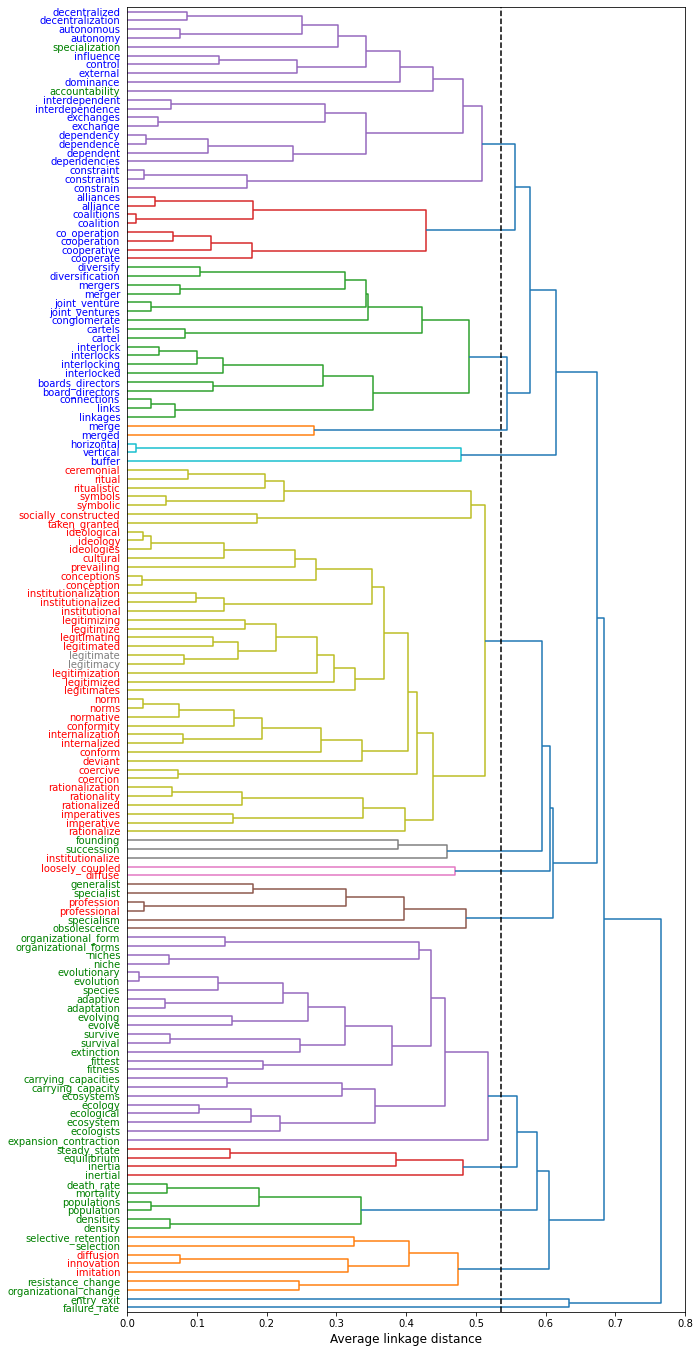




dendro_expanded_1982-1992_n4_right_021823
cluster threshold: 0.4328421275928007


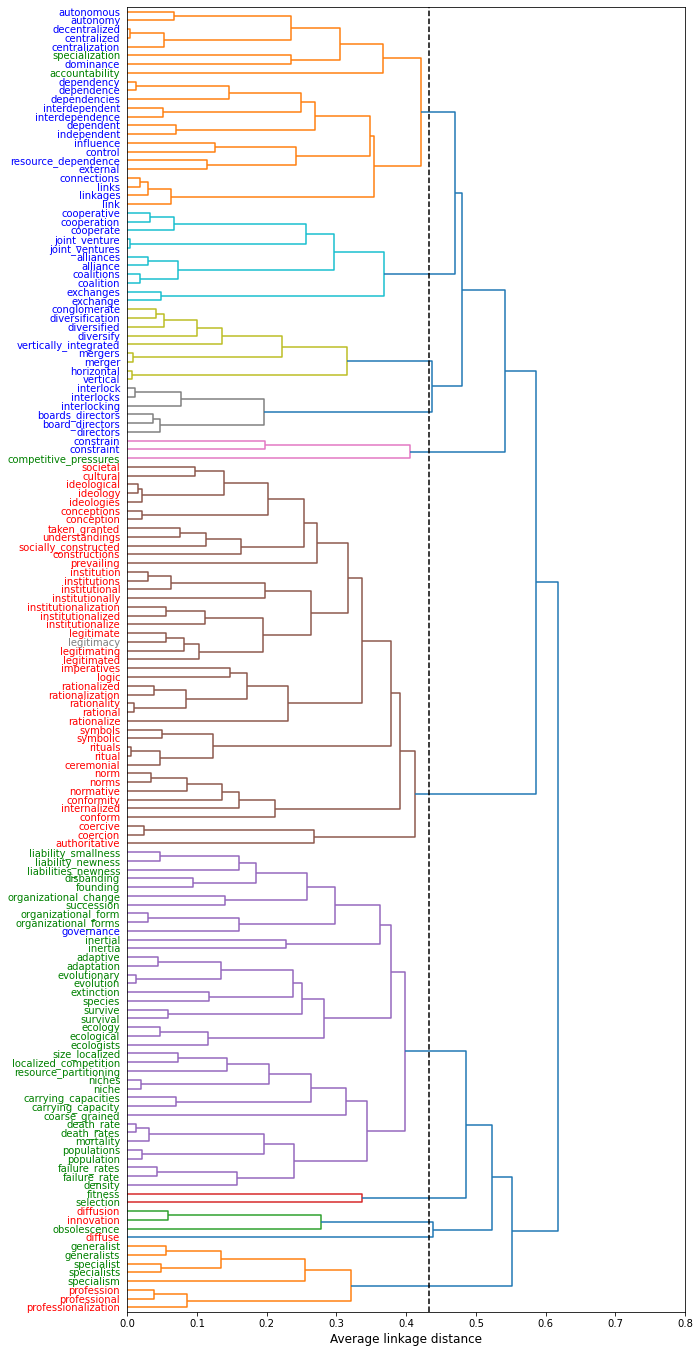




dendro_expanded_1993-2003_n4_right_021823
cluster threshold: 0.4000104388444509


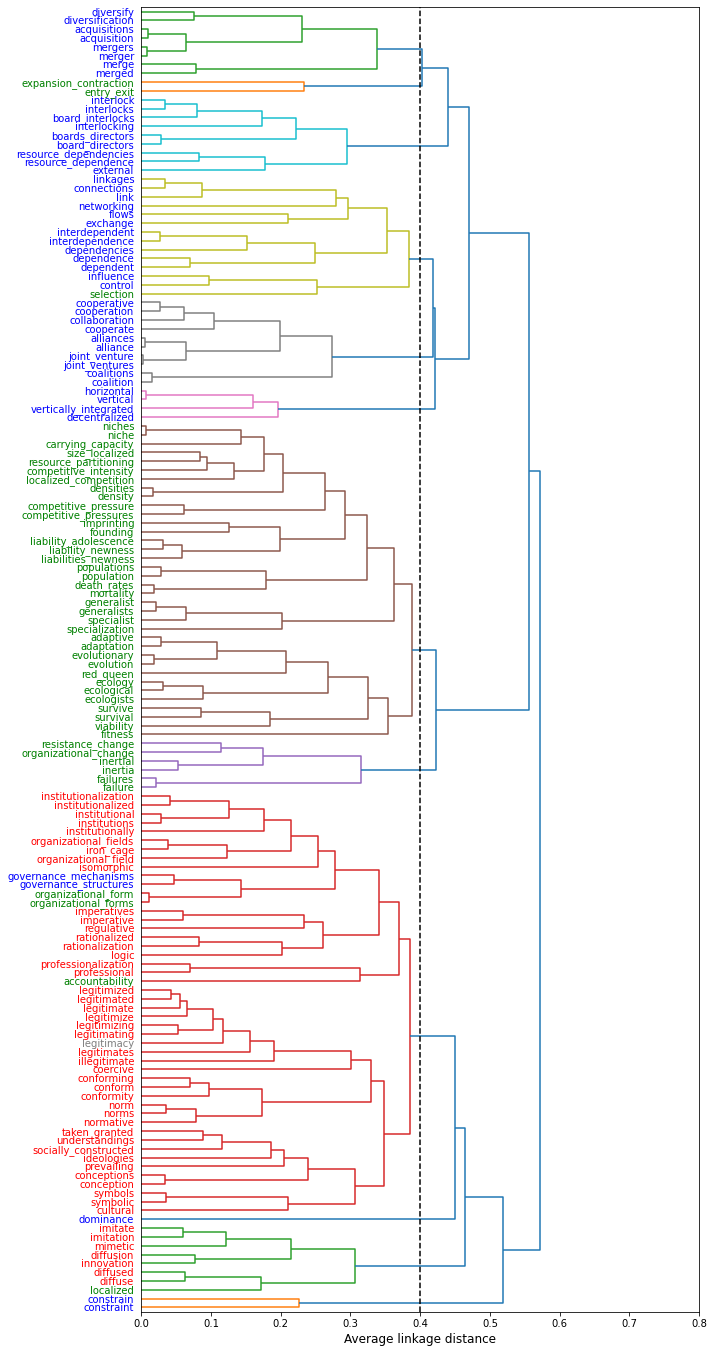




dendro_expanded_2004-2014_n4_right_021823
cluster threshold: 0.4047468738045233


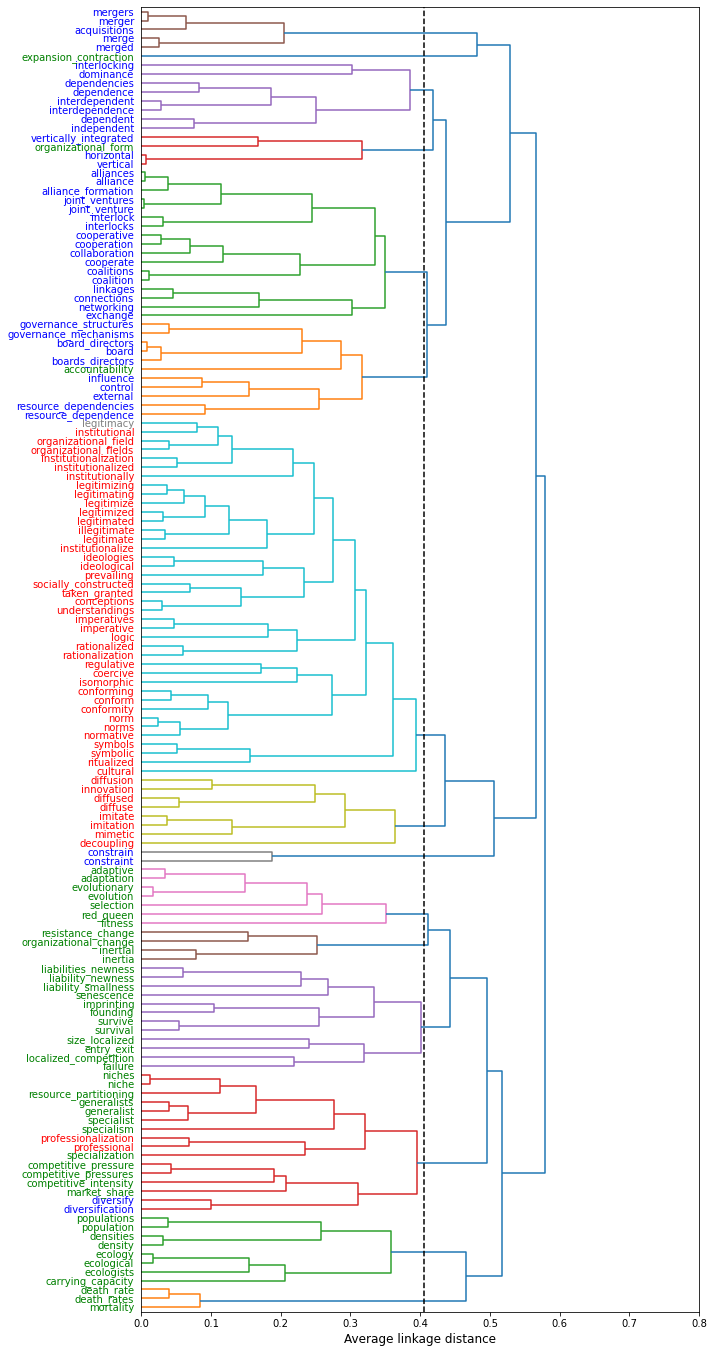

In [153]:
orientation = 'right' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram

for model, decade in zip(models, decades):
    print('\n\n')
    
    # Get list of words and color map
    all_dicts, all_color_map = load_dicts(decade)
    
    # Prepare and save dendrogram
    make_dendrogram(model = model, 
                    decade = decade,
                    dict_type = 'expanded',
                    orientation = orientation,
                    save_plot = True, 
                    color_map = all_color_map, 
                    unique_terms = all_dicts)

#### Seed dictionaries




dendro_core_1971-1981_n4_right_021823
cluster threshold: 0.5162421147125523


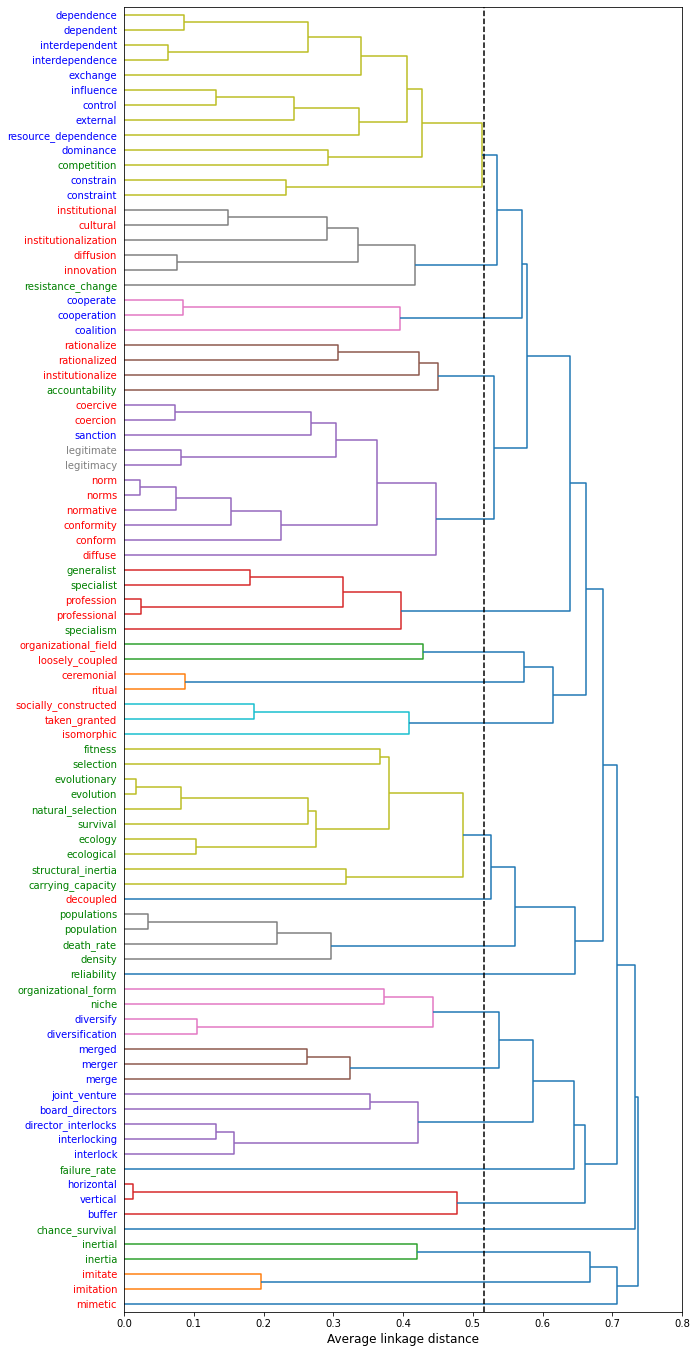




dendro_core_1982-1992_n4_right_021823
cluster threshold: 0.4814985528257158


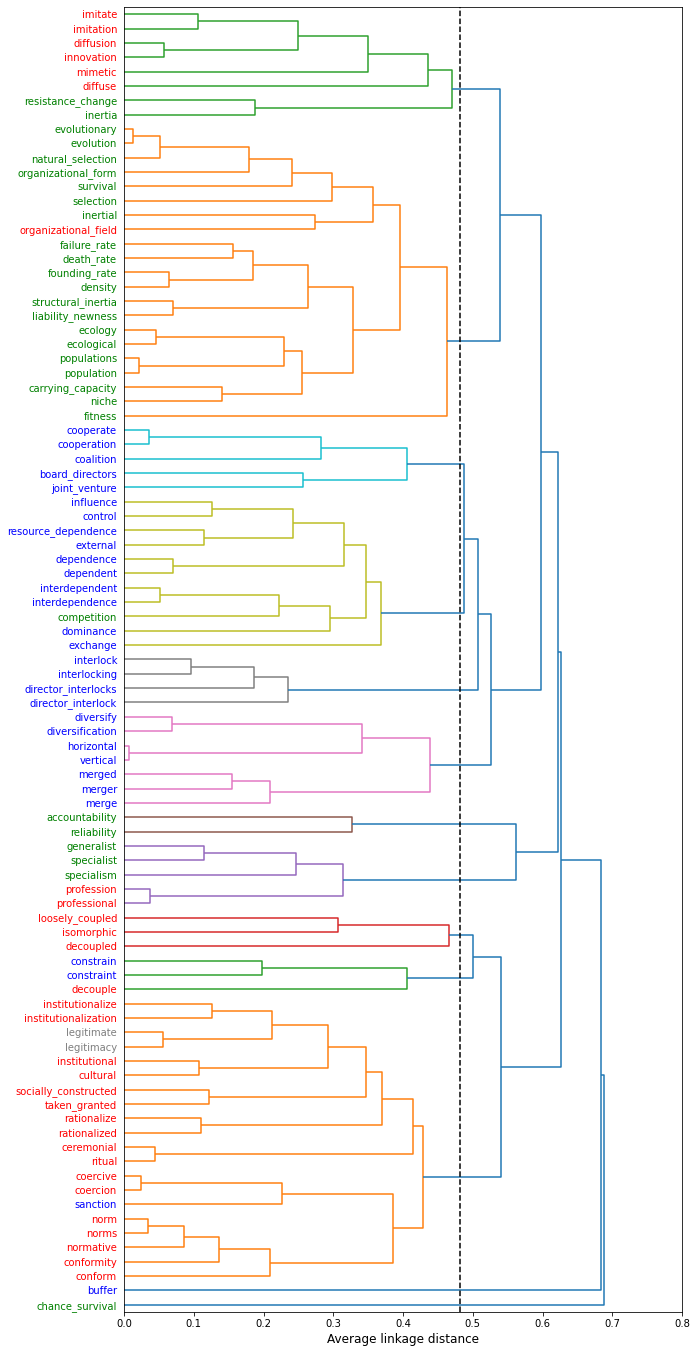




dendro_core_1993-2003_n4_right_021823
cluster threshold: 0.4497870831921989


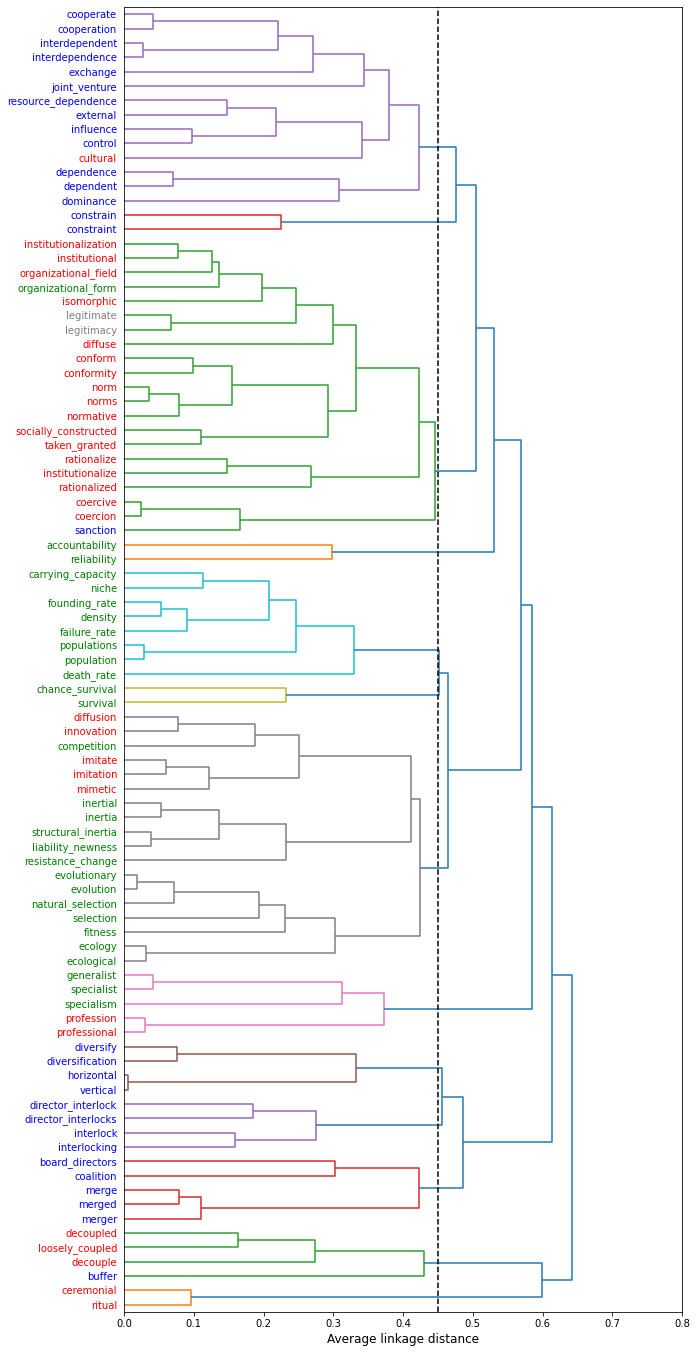




dendro_core_2004-2014_n4_right_021823
cluster threshold: 0.5278632416567774


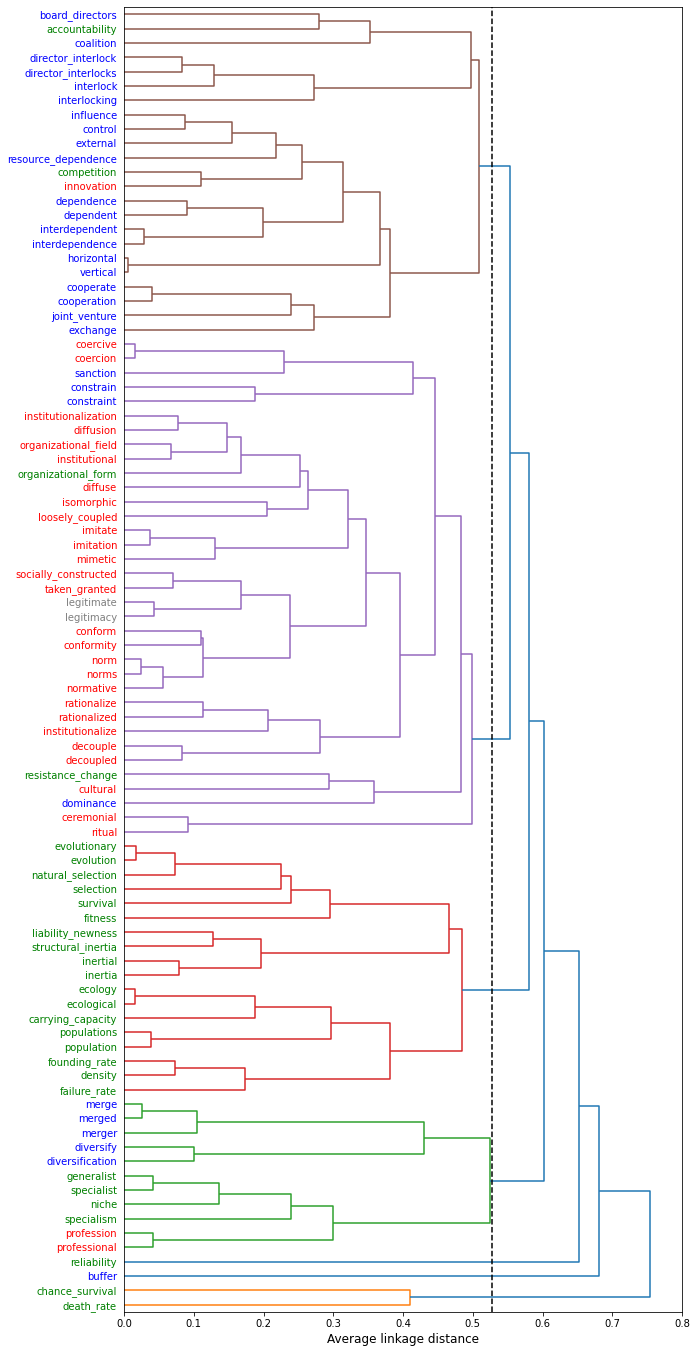

In [154]:
orientation = 'right' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram

for model, decade in zip(models, decades):
    print('\n\n')
    
    # Get list of words and color map
    all_dicts, all_color_map = load_dicts(decade, core = True)
    
    # Prepare and save dendrogram
    make_dendrogram(model = model, 
                    decade = decade,
                    dict_type = 'core',
                    orientation = orientation,
                    save_plot = True, 
                    color_map = all_color_map, 
                    unique_terms = all_dicts)